In [1]:
import numpy as np
import scipy as sp
import scipy.special
import matplotlib.pyplot as plt

In [2]:
def log_hyperm(a, b, z, smax=100):
    srange = np.arange(0, smax+1)
    summand = sp.special.gammaln(a + srange) - sp.special.gammaln(b + srange) \
        - sp.special.gammaln(1 + srange) + srange * np.log(z)
    log_summand = sp.special.logsumexp(summand)
    #print(log_summand)
    return log_summand + sp.special.gammaln(b) - sp.special.gammaln(a)

def log_hyperu(a, b, z, smax=100):
    first_term = sp.special.loggamma(1 - b + 0j) - sp.special.loggamma(a - b + 1 + 0j) + log_hyperm(a, b, z, smax=smax)
    
    scaling_second_term = sp.special.loggamma(b - 1 + 0j) - sp.special.gammaln(a) \
        + log_hyperm(a - b + 1, 2 - b, z, smax=smax)
    second_term = scaling_second_term + (1 - b) * np.log(z)
    
    return np.real(sp.special.logsumexp([first_term, second_term]))

In [3]:
def log_evidence(y, kernel, alpha1=0.21, alpha2=0.2, beta1=0.2, beta2=0.2):
    N = len(y)
    log_a_n = sp.special.gammaln(alpha1 + N/2) - sp.special.gammaln(alpha1/2) - sp.special.gammaln(alpha2) + \
            sp.special.gammaln(alpha2 + N/2) - N/2 * np.log(alpha1 * np.pi) + alpha2 * np.log(beta2)
    
    logdet = -0.5 * np.sum(np.log1p(np.real(np.linalg.eigvals(kernel))))
    
    qform = np.dot(y.T, np.linalg.solve(kernel + np.eye(kernel.shape[0]), y))[0,0]
    scaled_qform = -1 * (2 + alpha2 - alpha1) * np.log(qform)
    
    log_u = log_hyperu(N/2 + alpha2, 1 + alpha2 - alpha1, 2 * beta2 * alpha1 / qform)
    
    #print(log_a_n, logdet, scaled_qform, log_u)
    return log_a_n + logdet + scaled_qform + log_u

def occam_kernel(x, y = None, D = 3, scaling_exp = 1.):
    if y is None:
        y = x
    dist = x - y.T
    kernel_mat = 0. #np.ones_like(dist)
    for d in range(1, D+1):
        kernel_mat += np.cos(d * dist) / d**scaling_exp
    return kernel_mat / D

In [4]:
x = np.random.randn(150,1)
#y = -0.025 * x**5 + 0.015 * x**4 + 0.13 * x**3 + 0.15 * x**2 + 0.5 * x + 0.1 * np.random.randn(*x.shape)
y = np.sin(x*5) + 0.1 * np.random.randn(*x.shape)

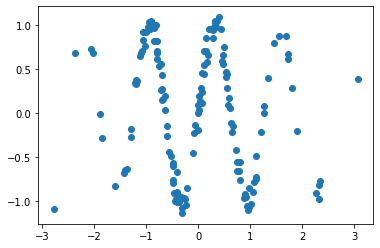

In [5]:
plt.scatter(x, y)

In [6]:
evidences = [[log_evidence(y, occam_kernel(x, D=d, scaling_exp=ii)) for d in range(1, 200)] for ii in range(0, 6)]

(257, 268)

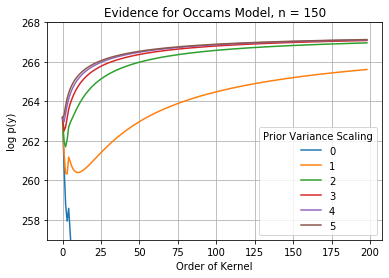

In [7]:
[plt.plot(e, label = str(ii)) for e, ii in zip(evidences, range(0, 6))]
plt.ylabel('log p(y)')
plt.xlabel('Order of Kernel')
plt.legend(title='Prior Variance Scaling')
plt.grid()
plt.title('Evidence for Occams Model, n = 150')
plt.ylim((257, 268))
#plt.savefig('evidences.pdf')

In [8]:
xpred = np.arange(-3, 3, 0.01).reshape(-1,1)
pred_means = [[occam_kernel(xpred, x, D=d, scaling_exp=ii) \
               @ np.linalg.solve(occam_kernel(x, D=d, scaling_exp=ii) \
                                 + 1e-4 * np.eye(150), y) for d in range(1, 5)] for ii in range(0, 6)]

Text(0.5, 1.0, 'Model Fits (1-5 Features)')

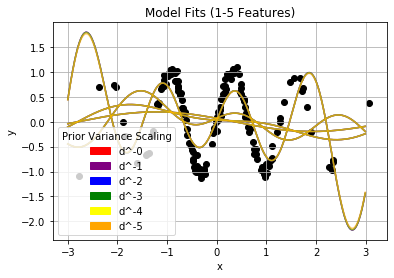

In [9]:
import matplotlib.patches as mpatches
colors = ['red', 'purple', 'blue', 'green', 'yellow', 'orange']
[[plt.plot(xpred, e, label = str(ii), 
           alpha = 0.5, 
           color=colors[ii]) for e in pred_scaling] for pred_scaling, ii in zip(pred_means, range(0, 6))]
plt.scatter(x, y, color = 'black')
plt.grid()
plt.xlabel('x')
plt.ylabel('y')

patches = [mpatches.Patch(color=cc, label='d^-'+str(ii)) for cc, ii in zip(colors, range(0,6))]
plt.legend(handles=patches, title='Prior Variance Scaling')
plt.title('Model Fits (1-5 Features)')
#plt.savefig('model_fits.pdf')

In [10]:
eigs = [[np.real(np.linalg.eig(
                        occam_kernel(x, 
                                          D=d, 
                                            scaling_exp=ii))[0]) for d in range(95, 100)] for ii in range(0, 6)]

In [11]:
linestyles = ['solid', ':', '-', '--', '-.']
# for ii, eig_row in enumerate(eigs):
#     for jj, eig in enumerate(eig_row):
#         plt.semilogy(eig+1e-6, color=colors[ii], linestyle=linestyles[jj], alpha = 0.3)
# plt.legend(handles=patches, title='Prior Variance Scaling')
# #plt.xlim((0, 20))
# plt.grid()
# plt.title('Eigenvalues of Kernel Matrix (190-200 Features)')
# plt.savefig('eigenvalues.pdf')

In [12]:
eigs = [[np.real(
        np.linalg.eig(occam_kernel(x, D=d, 
                                   scaling_exp=ii))[0]) for d in range(1, 200)] for ii in range(0,6)]

Text(0.5, 1.0, 'Eigenvalues of Kernel Matrix')

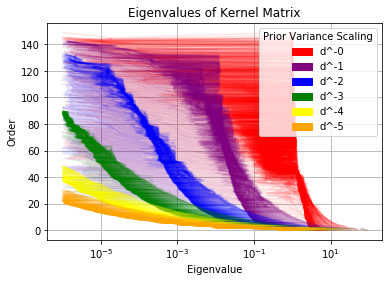

In [13]:
for ii, eig in enumerate(eigs):
    for e in eig:
        plt.semilogx(e[e>1e-6], np.arange(150)[e>1e-6], color = colors[ii], alpha = 0.1)
plt.legend(handles=patches, title='Prior Variance Scaling')
plt.ylabel('Order')
plt.xlabel('Eigenvalue')
#plt.xlim((0, 20))
plt.grid()
plt.title('Eigenvalues of Kernel Matrix')
#plt.savefig('eigenvalues.pdf')

/home/wesley/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in reciprocal
  
/home/wesley/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in power
  


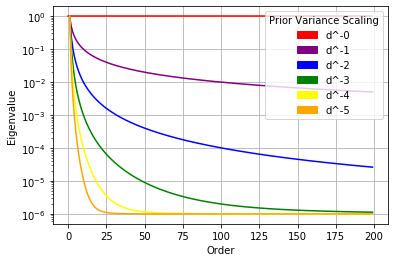

In [14]:
for ii, eig in enumerate(eigs):
    plt.semilogy((np.arange(0, 200)*1.)**-ii + 1e-6, color = colors[ii])
plt.legend(handles=patches, title='Prior Variance Scaling')
plt.xlabel('Order')
plt.ylabel('Eigenvalue')
#plt.xlim((0, 20))
plt.grid()

